<a href="https://colab.research.google.com/github/suhashj/Fake-Job-Description-Prediction/blob/main/NeuralNetworks(BLSTM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PROBLEM STATEMENT**

Employment scams are on the rise. According to CNBC, the number of employment scams doubled in 2018 as compared to 2017. Economic stress and the coronavirus impact have significantly reduced job availability and job loss for many individuals. This lead to high unemployment rate. In addition, the scams on job postings allow scammers to gain access to personal information, such as bank account details.Many people are falling prey to these scammers using the desperation that is caused by an unprecedented incident.

Hence, with classification model and the use of Natural Language Processing (NLP) , we aim to find an effective model that separate fraudulent and real job postings.

In [48]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Nlp library
import re
import nltk
from nltk.corpus import stopwords
import nltk as nlp
from sklearn.feature_extraction.text import CountVectorizer

# sklearn Library
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import explained_variance_score

#Tenserflow Library
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from tensorflow.keras.layers import Embedding,  Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
import warnings
warnings.filterwarnings("ignore")

In [49]:
df=pd.read_csv("/content/fake_job_postings.csv")

Check for null values

In [50]:
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [51]:
df.shape

(17880, 18)

In [52]:
df.fraudulent.value_counts()

0    17014
1      866
Name: fraudulent, dtype: int64

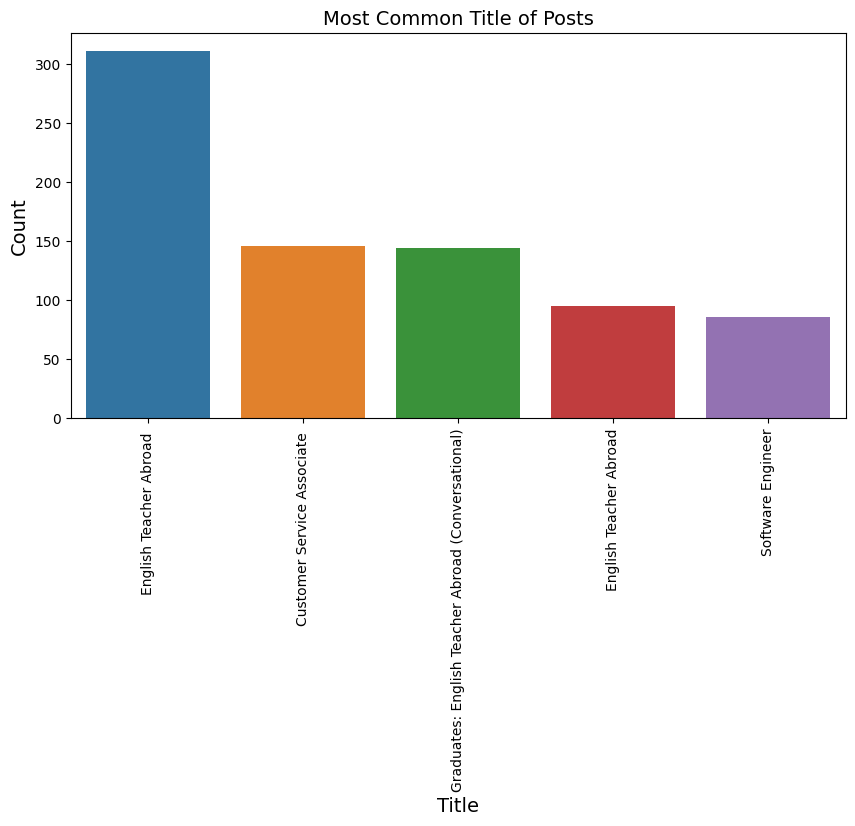

In [53]:
title = df.title.value_counts()[:5]
plt.figure(figsize = (10,5))
sb.barplot(x = title.index, y = title )
plt.title("Most Common Title of Posts", fontdict = {"fontsize" : 14})
plt.xlabel("Title", fontdict = {"fontsize" : 14})
plt.ylabel("Count", fontdict = {"fontsize" : 14})
plt.xticks(rotation=90);

In [54]:
df.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

Checking the correlation 

In [55]:
corr = df.corr().fraudulent
corr

job_id              0.079872
telecommuting       0.034523
has_company_logo   -0.261971
has_questions      -0.091627
fraudulent          1.000000
Name: fraudulent, dtype: float64

Filling all the null values with a blank

In [56]:
df.fillna(" ", inplace = True)

In [57]:
df['text'] = df['title'] + " " + df['department'] + \
             " " + df['company_profile'] + " " + \
             df['description'] + " " + \
             df['requirements'] + " " +\
             df['benefits'] + " " +\
             df['function'] + " " +\
             df['required_experience']+ " "+\
             df["required_education"]+ " " +\
             df["industry"]

Drop all the columns that is irrelevant for our processing

In [58]:
df=df.drop(columns = ['job_id','title','location','department', 'telecommuting',
                             'salary_range','company_profile','description','requirements','benefits','employment_type',
                             'required_experience','required_education','industry','function'])

In [59]:
df.head()

,has_company_logo,has_questions,fraudulent,text
0,1,0,0,"Marketing Intern Marketing We're Food52, and w..."
1,1,0,0,Customer Service - Cloud Video Production Succ...
2,1,0,0,Commissioning Machinery Assistant (CMA) Valo...
3,1,0,0,Account Executive - Washington DC Sales Our pa...
4,1,1,0,Bill Review Manager SpotSource Solutions LLC...


In [60]:

import nltk
nltk.download('punkt')
import nltk
nltk.download('stopwords')
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Preprocessing the data

In [61]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer


# Tokenization
df['text'] = df['text'].apply(lambda x: word_tokenize(x.lower()))

# Remove stop words
stop_words = set(stopwords.words('english'))
df['text'] = df['text'].apply(lambda x: [word for word in x if word not in stop_words])

# Lemmatization
lemmatizer = WordNetLemmatizer()
df['text'] = df['text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

# Remove punctuation and non-alphanumeric characters
df['text'] = df['text'].apply(lambda x: [word for word in x if word.isalnum()])

# Join tokens back into strings
df['text'] = df['text'].apply(lambda x: ' '.join(x))



In [62]:
text_list= df['text']

Max_features specifies that only top 10000 frequently occuring words in the training dataset will be used as features.

In [63]:
max_features = 10000


In [64]:
df['word count'] = [len(i.split(' ')) for i in df['text']]

In [65]:
sent_length = df['word count'].max()

In [66]:
sent_length

1370

In [67]:
df.head()

,has_company_logo,has_questions,fraudulent,text,word count
0,1,0,0,marketing intern marketing food52 created grou...,230
1,1,0,0,customer service cloud video production succes...,535
2,1,0,0,commissioning machinery assistant cma valor se...,195
3,1,0,0,account executive washington dc sale passion i...,472
4,1,1,0,bill review manager spotsource solution llc gl...,343


Now we will do a WordCloud

In [68]:
fake_jobs = df[df["fraudulent"] == 1]["text"]
real_jobs = df[df["fraudulent"] == 0]["text"]

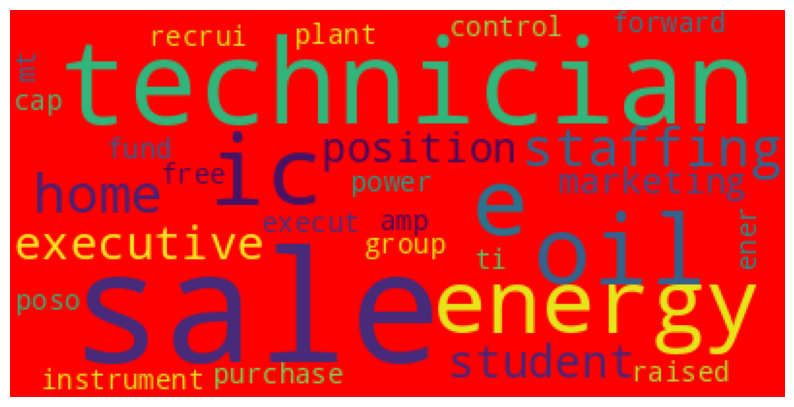

In [69]:
wordcloud = WordCloud(max_font_size=80,max_words=30, background_color="red").generate(str(fake_jobs))
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

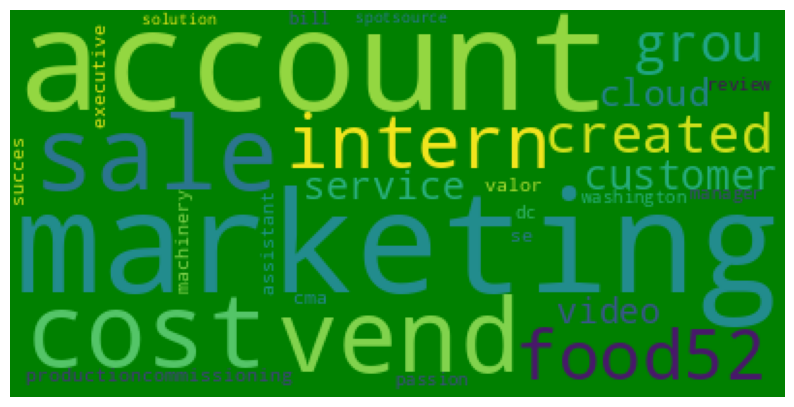

In [70]:
wordcloud = WordCloud(max_font_size=80,max_words=30, background_color="green").generate(str(real_jobs))
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

The tokenizer is an object that will be used to convert the text into a sequence of integers that can be fed into a neural network.

In [71]:
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
# create the tokenizer
t = Tokenizer(num_words = max_features)
# fit the tokenizer on the documents
t.fit_on_texts(text_list)

This is a method that takes in the list of strings and converts each string into a sequence of integers.

In [72]:
encoded_docs = t.texts_to_sequences(text_list)

In [73]:
embedded_docs=pad_sequences(encoded_docs,padding='post',maxlen=sent_length)
print(embedded_docs)

[[  20  802   20 ...    0    0    0]
 [   6    4  610 ...    0    0    0]
 [4299 2373  449 ...    0    0    0]
 ...
 [  19  218  267 ...    0    0    0]
 [ 811  222  939 ...    0    0    0]
 [  46   52   85 ...    0    0    0]]


Specifying the target variable

In [74]:
X=embedded_docs
y=df['fraudulent']

In [75]:
X.shape,y.shape

((17880, 1370), (17880,))

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 32)

In [77]:
print("X_train shape: ",X_train.shape)
print("X_test shape : ",X_test.shape )
print("y_train shape: ",y_train.shape)
print("y_test shape : ",y_test.shape)

X_train shape:  (12516, 1370)
X_test shape :  (5364, 1370)
y_train shape:  (12516,)
y_test shape :  (5364,)



Embedding vector features is a hyperparameter that is used to specify the size of the vector used to represent each word in the text. 

I tried using BLSTM as the accuracy was more and it took lesser computational time compared to lstm

In [78]:
embedding_vector_features=100
model1=Sequential()
model1.add(Embedding(max_features,embedding_vector_features,input_length=sent_length))
model1.add(Bidirectional(LSTM(30)))
model1.add(Dense(1,activation='sigmoid'))
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model1.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1370, 100)         1000000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 60)               31440     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 1)                 61        
                                                                 
Total params: 1,031,501
Trainable params: 1,031,501
Non-trainable params: 0
_________________________________________________________________
None


In [79]:

hist = model1.fit(X_train, y_train, epochs = 20, batch_size = 32, validation_data=(X_test,y_test))

Epoch 1/20
392/392 [==============================] - 94s 231ms/step - loss: 0.1138 - accuracy: 0.9685 - val_loss: 0.0639 - val_accuracy: 0.9814
Epoch 2/20
392/392 [==============================] - 60s 152ms/step - loss: 0.0324 - accuracy: 0.9903 - val_loss: 0.0602 - val_accuracy: 0.9814
Epoch 3/20
392/392 [==============================] - 46s 117ms/step - loss: 0.0162 - accuracy: 0.9954 - val_loss: 0.0614 - val_accuracy: 0.9842
Epoch 4/20
392/392 [==============================] - 42s 106ms/step - loss: 0.0077 - accuracy: 0.9980 - val_loss: 0.0708 - val_accuracy: 0.9832
Epoch 5/20
392/392 [==============================] - 36s 93ms/step - loss: 0.0041 - accuracy: 0.9986 - val_loss: 0.0841 - val_accuracy: 0.9845
Epoch 6/20
392/392 [==============================] - 35s 88ms/step - loss: 0.0020 - accuracy: 0.9994 - val_loss: 0.0930 - val_accuracy: 0.9849
Epoch 7/20
392/392 [==============================] - 34s 86ms/step - loss: 0.0018 - accuracy: 0.9996 - val_loss: 0.0822 - val_accur

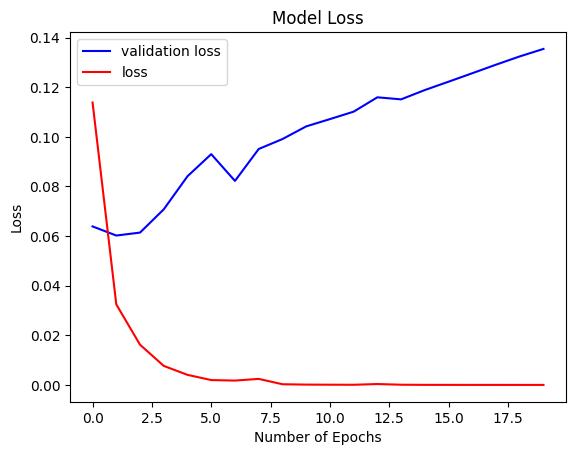

In [80]:
plt.plot(hist.history['val_loss'], color='b', label="validation loss")
plt.plot(hist.history['loss'], color='red', label="loss")
plt.title("Model Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

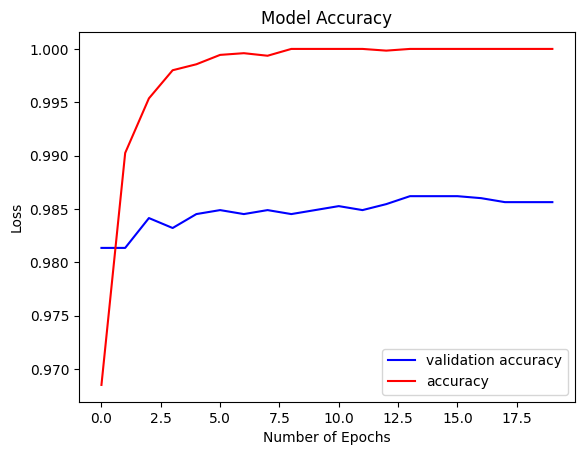

In [81]:
plt.plot(hist.history['val_accuracy'], color='b', label="validation accuracy")
plt.plot(hist.history['accuracy'], color='red', label="accuracy")
plt.title("Model Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [82]:
def eval_metrics(actual, prediction):
    print("Accuracy Score: {}".format(accuracy_score(actual, prediction)))
    print("Recall Score: {}".format(recall_score(actual, prediction)))
    print("f1 Score: {}".format(f1_score(actual, prediction)))

In [83]:
y_pred = model1.predict(X_test)

168/168 [==============================] - 6s 30ms/step


In [84]:
y_train_pred = model1.predict(X_train)


392/392 [==============================] - 11s 27ms/step


In [85]:
#print(confusion_matrix(y_test, y_pred))

If you need to use binary classification metrics but your target variable is continuous, you can convert it into a binary category by setting a threshold

In [86]:
y_pred = (y_pred > 0.5)

In [87]:
y_train_pred = (y_train_pred > 0.5)

In [88]:
print(confusion_matrix(y_test, y_pred))

[[5088   18]
 [  59  199]]


In [89]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5106
           1       0.92      0.77      0.84       258

    accuracy                           0.99      5364
   macro avg       0.95      0.88      0.92      5364
weighted avg       0.99      0.99      0.99      5364



In [90]:
eval_metrics(y_test, y_pred)

Accuracy Score: 0.9856450410141685
Recall Score: 0.7713178294573644
f1 Score: 0.8378947368421052


In [91]:
model1.save("fake-final-classification.h5")

In [92]:
!pip install streamlit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import streamlit as st
import re
import nltk
from nltk.corpus import stopwords
import nltk as nlp
from sklearn.feature_extraction.text import CountVectorizer

# Load the saved model
model = load_model("/content/fake-final-classification.h5")

# Preprocess the input text
def preprocess_text(text):
    text = re.sub("[^a-zA-Z]", " ", text)
    text = text.lower()
    text = re.sub("[^a-zA-Z]", " ", text)
    text = text.lower()
    text = text.strip()
    text = nltk.word_tokenize(text)
    text = [word for word in text if not word in set(stopwords.words("english"))] # dropping stopwords
    lemma = nlp.WordNetLemmatizer()
    text = [lemma.lemmatize(word) for word in text]
    text = " ".join(text)
    text = text.replace('  ',' ')
    return text

# Make a prediction function

def predict(text):

    preprocessed_text = preprocess_text(text)
    encoded_text = t.texts_to_sequences([preprocessed_text])
    padded_text = pad_sequences(encoded_text, padding='post', maxlen=sent_length)
    prediction = model.predict(padded_text)
    st.write(prediction)

    if prediction > 0.5:
        return ("This job posting is **fraudulent**.")
    else:
        return ("This job posting is **NOT Fraudulent**")

# Example usage
text = input(('Enter the job description:'))
prediction = predict(text)
print(prediction)